Copyright (C) 2021-2022, Intel Corporation

SPDX-License-Identifier: Apache-2.0

Major Portions of this code are copyright of their respective authors and released under the Apache License Version 2.0:
- onnx, Copyright 2021-2022. For licensing see https://github.com/onnx/models/blob/master/LICENSE

# Object detection with YOLOv4 in Python using OpenVINO™ Execution Provider:

1. The Object detection sample uses a YOLOv4 Deep Learning ONNX Model from the ONNX Model Zoo.


2. The sample involves presenting an image to ONNX Runtime (RT), which uses the OpenVINO™ Execution Provider to run inference on various Intel hardware devices as mentioned before and perform object detection to detect up to 80 different objects like person, bicycle, car, motorbike and much more from the coco dataset.


4. Once the inferencing is done on the sample, the recording of the same also gets downloaded on the disk.

The source code for this sample is available [here](https://github.com/microsoft/onnxruntime-inference-examples/tree/main/python/OpenVINO_EP/yolov4_object_detection).

## Install Requirements

In [1]:
# !pip -q install --upgrade pip
# !pip -q install folium==0.2.1
# !pip -q install imgaug==0.2.6
# !pip -q install certifi==2022.5.18.1
# !pip -q install flatbuffers==2.0
# !pip install protobuf==3.20.1
# !pip -q install numpy==1.21.6
# !pip -q install onnx==1.11.0
# !pip -q install opencv-python==4.5.5.64
# !pip -q install scipy==1.7.3
# !pip -q install typing-extensions==4.1.1
# !pip -q install onnxruntime-openvino==1.11.0

## Import Necessary Resources

In [2]:
import cv2
import numpy as np
from onnx import numpy_helper
import onnx
import onnxruntime as rt
import os
from PIL import Image
from scipy import special
import colorsys
import random
import argparse
import sys
import time
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

## Get the model and input

In [3]:
files = os.listdir('.')
if ('yolov4_anchors.txt' not in files):
  !wget https://raw.githubusercontent.com/microsoft/onnxruntime-inference-examples/main/python/OpenVINO_EP/yolov4_object_detection/yolov4_anchors.txt
if ('coco.names' not in files):
  !wget https://raw.githubusercontent.com/microsoft/onnxruntime-inference-examples/main/python/OpenVINO_EP/yolov4_object_detection/coco.names
if ('yolov4.onnx' not in files):
  !wget https://github.com/onnx/models/blob/main/vision/object_detection_segmentation/yolov4/model/yolov4.onnx?raw=true -O yolov4.onnx
if ('cat.jpg' not in files):
  !wget https://storage.openvinotoolkit.org/data/test_data/images/cat.jpg

## Preprocess

### Reshape the input to align with the model


When we are using a pre-trained model, which is trained & fine-tuned using a fixed image size as input, we should resize our image to a shape which is expected by the model. The image reshaped using a scaling factor which is a ratio between the desired height/width and the actual image height/width.
    $$
        scale = min \biggl( \frac{\text{target height}}{\text{input image height}}, \frac{\text{target width}}{\text{input image width}} \biggl)
    $$
Using the $scale$-factor, image height & width are calculated which is then re-shaped to the desired image size using the `opencv` package. Here this is acheived by the `image_preprocess` helper function.


In [4]:
def image_preprocess(image, target_size, gt_boxes=None):
    
    ih, iw = target_size
    h, w, _ = image.shape

    scale = min(iw/w, ih/h)

    nw, nh = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_padded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_padded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_padded = image_padded / 255.

    if gt_boxes is None:
        return image_padded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_padded, gt_boxes

### Check file paths

`check_model_extention` is a helper function which checks if the model is present in the location specified. It also validates the model by checking the model file extension.  
The expected model file should be of `<model_name>.onnx` format.

In [5]:
def check_model_extension(fp):
  # Split the extension from the path and normalise it to lowercase.
  ext = os.path.splitext(fp)[-1].lower()

  # Now we can simply use != to check for inequality, no need for wildcards.
  if(ext != ".onnx"):
    raise Exception(fp, "is an unknown file format. Use the model ending with .onnx format")
  
  if not os.path.exists(fp):
    raise Exception("[ ERROR ] Path of the onnx model file is Invalid")

## Postprocess

### Defines anchor boxes


Anchor boxes are a set of predefined bounding boxes of a certain height and width. These boxes are defined to capture the scale and aspect ratio of specific object classes we want to detect and are typically chosen based on object sizes in the training datasets. The use of anchor boxes improves the speed and efficiency for the detection portion of a deep learning neural network framework. Anchor boxes, facilitates the evaluation of object predictions at once, making real-time object detection systems possible.

The following function takes the anchor box prediction probabilities and refines it corresponding to the tiled anchor boxes of the input image.

In [6]:
def postprocess_bbbox(pred_bbox):
    for i, pred in enumerate(pred_bbox):
        conv_shape = pred.shape
        output_size = conv_shape[1]
        conv_raw_dxdy = pred[:, :, :, :, 0:2]
        conv_raw_dwdh = pred[:, :, :, :, 2:4]
        xy_grid = np.meshgrid(np.arange(output_size), np.arange(output_size))
        xy_grid = np.expand_dims(np.stack(xy_grid, axis=-1), axis=2)

        xy_grid = np.tile(np.expand_dims(xy_grid, axis=0), [1, 1, 1, 3, 1])
        xy_grid = xy_grid.astype(float)

        pred_xy = ((special.expit(conv_raw_dxdy) * XYSCALE[i]) - 0.5 * (XYSCALE[i] - 1) + xy_grid) * STRIDES[i]
        pred_wh = (np.exp(conv_raw_dwdh) * ANCHORS[i])
        pred[:, :, :, :, 0:4] = np.concatenate([pred_xy, pred_wh], axis=-1)

    pred_bbox = [np.reshape(x, (-1, np.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = np.concatenate(pred_bbox, axis=0)
    return pred_bbox

### Removes boundary boxs with a low detection probability

The following function takes input as the prediction boxes (obtained by the previous function) and processes them to create bounding boxes. It also gets rid of certain prediction boxes based on a score threshold value.

In [7]:
def postprocess_boxes(pred_bbox, org_img_shape, input_size, score_threshold):
    valid_scale=[0, np.inf]
    pred_bbox = np.array(pred_bbox)

    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    pred_prob = pred_bbox[:, 5:]

    # # (1) (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    # # (2) (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = org_img_shape
    resize_ratio = min(input_size / org_w, input_size / org_h)

    dw = (input_size - resize_ratio * org_w) / 2
    dh = (input_size - resize_ratio * org_h) / 2

    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # # (3) clip some boxes that are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0

    # # (4) discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # # (5) discard some boxes with low scores
    classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    score_mask = scores > score_threshold
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]

    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

### Calculate the Intersection Over Union value

Intersection over Union (IoU) is an evaluation technique for understanding how well the model is performing. However, during the time of inference, it is used to suppress the bounding-boxes that have a high IoU value with the bounding box with maximum probability.

In [8]:
def bboxes_iou(boxes1, boxes2):
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return ious

### Non Max Suppression: select the most appropriate bounding box


It is the process of taking the boxes with maximum probability and suppressing the near-by boxes with non-max probabilities.  
This is process is repeated until for a single object-class only one box is remaining.

In [9]:
def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
    """
    :param bboxes: (xmin, ymin, xmax, ymax, score, class)
    Note: soft-nms, https://arxiv.org/pdf/1704.04503.pdf
          https://github.com/bharatsingh430/soft-nms
    """
    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]

        while len(cls_bboxes) > 0:
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            assert method in ['nms', 'soft-nms']

            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0

            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes

### Load class name from a file

- 80 different classes: person, bicycle, car, motorbike, aeroplane, bus, train, truck, etc.

In [10]:
def read_class_names(class_file_name):
    names = {}
    with open(class_file_name, 'r') as data:
        for ID, name in enumerate(data):
            names[ID] = name.strip('\n')
    return names

### Output an image with all the bounding boxes

Below function is an helper function to draw the bounding box in the input image.

In [11]:
def draw_bbox(image, bboxes, classes=read_class_names("coco.names"), show_label=True):
    """
    bboxes: [x_min, y_min, x_max, y_max, probability, cls_id] format coordinates.
    """

    num_classes = len(classes)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        fontScale = 0.5
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 600)
        c1, c2 = (coor[0], coor[1]), (coor[2], coor[3])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)

        if show_label:
            bbox_mess = '%s: %.2f' % (classes[class_ind], score)
            t_size = cv2.getTextSize(bbox_mess, 0, fontScale, thickness=bbox_thick//2)[0]
            cv2.rectangle(image, c1, (c1[0] + t_size[0], c1[1] - t_size[1] - 3), bbox_color, -1)
            cv2.putText(image, bbox_mess, (c1[0], c1[1]-2), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale, (0, 0, 0), bbox_thick//2, lineType=cv2.LINE_AA)
            print('{} detected in frame with {}% probability '.format(classes[class_ind], score*100))
        
    return image

### Load the anchors from a file

The predefined anchors for the data-set on which the YoloV4 model was trained are loaded.

In [12]:
def get_anchors(anchors_path, tiny=False):
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = np.array(anchors.split(','), dtype=np.float32)
    return anchors.reshape(3, 3, 2)

## Inference

### Create a session for inference based on the device selected

To perform inference using the ONNX-Runtime it performed using the below simple steps:
    
1. Create a ONNX Runtime Session Option instance using `onnxruntime.SessionOptions()`
2. Using the session options instance create a Inference Session object by passing the model and the execution provider as arguments.
Execution Providers are the hardware device options e.g. CPU, Myriad, GPU, etc. on which the session will be executed.

The below `create_sess` function actually takes care of the above steps. All we need to do is pass the device arguement to it. It'll return the appropriate session according to the device.

The device option should be chosen from any one of the below options:  
- `cpu, CPU_FP32, GPU_FP32, GPU_FP16, MYRIAD_FP16, VADM_FP16`

In [13]:
def create_sess(device):
  so = rt.SessionOptions()
  so.log_severity_level = 3
  if (device == 'cpu'):
    print("Device type selected is 'cpu' which is the default CPU Execution Provider (MLAS)")
    #Specify the path to the ONNX model on your machine and register the CPU EP
    sess = rt.InferenceSession(model, so, providers=['CPUExecutionProvider'])
  elif (device == 'CPU_FP32' or device == 'GPU_FP32' or device == 'GPU_FP16' or device == 'MYRIAD_FP16' or device == 'VADM_FP16'):
    #Specify the path to the ONNX model on your machine and register the OpenVINO EP
    sess = rt.InferenceSession(model, so, providers=['OpenVINOExecutionProvider'], provider_options=[{'device_type' : device}])
    print("Device type selected is: " + device + " using the OpenVINO Execution Provider")
    '''
    other 'device_type' options are: (Any hardware target can be assigned if you have the access to it)
    'CPU_FP32', 'GPU_FP32', 'GPU_FP16', 'MYRIAD_FP16', 'VAD-M_FP16'
    '''
  else:
    raise Exception("Device type selected is not [cpu, CPU_FP32, GPU_FP32, GPU_FP16, MYRIAD_FP16, VADM_FP16]")

  # Get the input name of the model
  input_name = sess.get_inputs()[0].name

  return sess, input_name

### Specify the path to anchors file on your machine

In [14]:
ANCHORS = "yolov4_anchors.txt"  
STRIDES = [8, 16, 32]
XYSCALE = [1.2, 1.1, 1.05]
ANCHORS = get_anchors(ANCHORS)
STRIDES = np.array(STRIDES)

### Specify the path to model, and image

In [15]:
model = "yolov4.onnx"
image = "cat.jpg"

### Validate model file path

In [16]:
check_model_extension(model)

### Setup input and output

In [17]:
if (image):
    # Open the image file
    if not os.path.isfile(image):
        print("Input image file ", image, " doesn't exist")
        sys.exit(1)
    cap = cv2.imread(image)
    output_file = image[:-4]+'_yolov4_out_py.jpg'

### Run the inference with CPU Execution Provider

Now the `yolov4.onnx` model will run inference on `cat.jpg` image using the below two execution providers:
- `cpu`: default CPU Execution Provider (MLAS)  
- `CPU_FP32`: Execution on CPU with OpenVino Execution Provider

The below code block performs the following operations:

1. Creates a Onnx Runtime Session using `cpu` as device
2. Loads the input image and performs pre-processing using `image_preprocess` function
3. Performs prediction on the same image for $100$-times
4. Calculates average inference time
5. Performs post-processing, non-max suppression & bounding-box drawing using the predicted outputs from the model


Device type selected is 'cpu' which is the default CPU Execution Provider (MLAS)
PREDICTION - BEGIN
Avg Inference time in ms: 188.552387
PREDICTION - END
cat detected in frame with 97.1569299697876% probability 




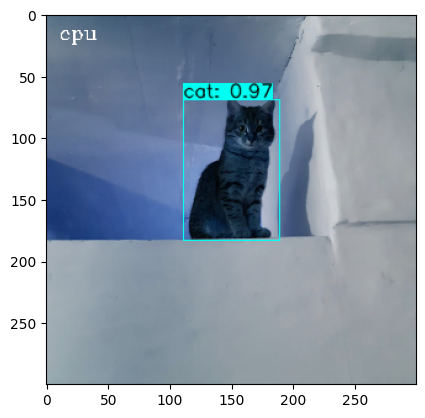

In [18]:
### create a session with cpu which is the default CPU Execution Provider
sess, input_name = create_sess("cpu")

input_size = 416
original_image = cap.copy()
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]

image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
image_data = image_data[np.newaxis, ...].astype(np.float32)

outputs = sess.get_outputs()
output_names = list(map(lambda output: output.name, outputs))

print("PREDICTION - BEGIN")
#warmup
sess.run(output_names, {input_name: image_data})

start = time.time()
for i in range(100):
  detections = sess.run(output_names, {input_name: image_data})

end = time.time()
inference_time = end - start
print('Avg Inference time in ms: %f' % (inference_time/100 * 1000))
print("PREDICTION - END")  

pred_bbox = postprocess_bbbox(detections)
bboxes = postprocess_boxes(pred_bbox, original_image_size, input_size, 0.25)
bboxes = nms(bboxes, 0.213, method='nms')
image_out = draw_bbox(original_image, bboxes)

cv2.putText(image_out,"cpu",(10,20),cv2.FONT_HERSHEY_COMPLEX,0.5,(255,255,255),1)

image_out = cv2.cvtColor(image_out, cv2.COLOR_BGR2RGB)
# cv2_imshow(image_out)

plt.imshow(image_out)
#Write the frame with the detection boxes
cv2.imwrite(output_file, image_out.astype(np.uint8))

print('\n')

### Run the inference **with** OpenVINO Execution Provider

The below code block performs the same opertions as before with `CPU_FP32` as OpenVino Execution Provider as device.

Device type selected is: CPU_FP32 using the OpenVINO Execution Provider
PREDICTION - BEGIN
Avg Inference time in ms: 150.713468
PREDICTION - END
cat detected in frame with 97.15692400932312% probability 






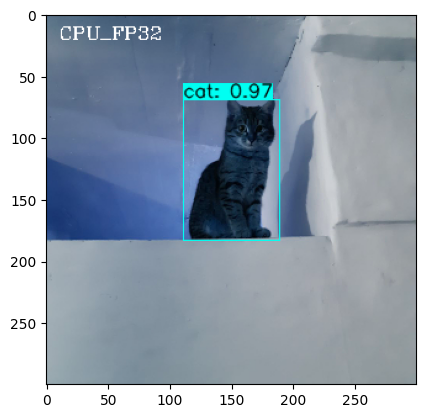

In [19]:
### create a session with CPU_FP32 using the OpenVINO Execution Provider
sess, input_name = create_sess("CPU_FP32")

input_size = 416
original_image = cap.copy()
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]

image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
image_data = image_data[np.newaxis, ...].astype(np.float32)

outputs = sess.get_outputs()
output_names = list(map(lambda output: output.name, outputs))

print("PREDICTION - BEGIN")
#warmup
sess.run(output_names, {input_name: image_data})

start = time.time()
for i in range(100):
  detections = sess.run(output_names, {input_name: image_data})

end = time.time()
inference_time = end - start
print('Avg Inference time in ms: %f' % (inference_time/100 * 1000))
print("PREDICTION - END")  

pred_bbox = postprocess_bbbox(detections)
bboxes = postprocess_boxes(pred_bbox, original_image_size, input_size, 0.25)
bboxes = nms(bboxes, 0.213, method='nms')
image_out = draw_bbox(original_image, bboxes)

cv2.putText(image_out,"CPU_FP32",(10,20),cv2.FONT_HERSHEY_COMPLEX,0.5,(255,255,255),1)

image_out = cv2.cvtColor(image_out, cv2.COLOR_BGR2RGB)
# cv2_imshow(image_out)
plt.imshow(image_out)
print('\n')

#Write the frame with the detection boxes
cv2.imwrite(output_file, image_out.astype(np.uint8))

print('\n')